In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [5]:
with open(script_paths[1]) as f:
    line = f.read()
    line = line.strip()
    result = list(map(int, line.split(' ')))

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [8]:
print('char2index len: {}'.format(len(char2index)))

print('index2char len: {}'.format(len(index2char)))

char2index len: 820
index2char len: 820


In [9]:
pure_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    pure_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    pure_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    pure_jamo_list.append(chr(unicode))

pure_jamo_list += [' ', '!', ',', '.', '?']

print(pure_jamo_list)

['ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', ' ', '!', ',', '.', '?']


In [10]:
korean_script_list = list()
jamo_script_list = list()

# true_jamo_regex_not  = re.compile(u'[^, .?!\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

# valid_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

count = 0

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = list(jamotools.split_syllables(line, 'JAMO'))
        
#         print(len(jamo))
        for i, c in enumerate(jamo):
            if c not in pure_jamo_list:
                jamo[i] = '*'
        
        jamo = ''.join(jamo)
#         jamo_filtered = ''.join(true_jamo_regex.findall(jamo))
#         jamo_filtered = re.sub(true_jamo_regex_not, '*', jamo)
        jamo_script_list.append(jamo)
        
#         print(line)
#         print(jamo) 
        
#         if count == 100:
#             break
        
#         count += 1

In [11]:
def find_starting_point(coef, thres = 0.1, margin = 10):
    starting_point = 0
    for i in range(len(coef) - 1):
        if (coef[i] <= thres and coef[i+1] > thres):
            starting_point = i
            break
            
    starting_point = starting_point - margin
    
    if starting_point < 0:
        starting_point = 0
    
    return starting_point

def find_ending_point(coef, thres = 0.1, margin = 10):
    for i in range(len(coef) - 1, 0, -1):
        if (coef[i] <= thres and coef[i-1] > thres):
            ending_point = i
            break
            
    ending_point = ending_point + margin
    
    if ending_point > len(coef):
        ending_point = len(coef)

    return ending_point

In [12]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        
        self.shuffle_step = 4
        
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(16)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                batched_lev_truth = batch[4]
                batched_lev_truth_loss_mask = batch[5]
                
                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        lev_truth_length_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        max_lev_truth_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            lev_truth_length_list.append(len(lev_truth))
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            if (len(lev_truth) > max_lev_truth_len):
                max_lev_truth_len = len(lev_truth)
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        batched_lev_truth = torch.zeros(count, max_lev_truth_len)
        batched_lev_truth_loss_mask = torch.zeros(count, max_lev_truth_len)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
            batched_lev_truth[order, :lev_truth_length_list[order]] = torch.tensor(lev_truth_list[order])
            batched_lev_truth_loss_mask[order, :lev_truth_length_list[order]] = torch.ones(lev_truth_length_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        
        # Cut-off paddings
        coef = np.sum(Sxx, 0)
        Sxx = Sxx[:, find_starting_point(coef):find_ending_point(coef)]

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input
#         return torch.zeros(1, 1, 1)

In [13]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [14]:
# unicode_jamo_list = list()

# # 초성
# for unicode in range(0x1100, 0x1113):
#     unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# # 중성
# for unicode in range(0x1161, 0x1176):
#     unicode_jamo_list.append(chr(unicode))
# # 종성
# for unicode in range(0x11A8, 0x11C3):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('A'), ord('Z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('a'), ord('z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('0'), ord('9') + 1):
#     unicode_jamo_list.append(chr(unicode))

# unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
#                       '-', '<s>', '</s>']
# unicode_jamo_list.sort()
# # '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
# unicode_jamo_list = ['_'] + unicode_jamo_list

# tokenizer = Tokenizer(unicode_jamo_list)
# jamo_tokens = tokenizer.word2num(unicode_jamo_list)

unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '!', ',', '.', '?', '<s>', '</s>', '*']

unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [15]:
print(unicode_jamo_list)
print(jamo_tokens)

['_', ' ', '!', '*', ',', '.', '</s>', '<s>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


In [16]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [17]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [18]:
batch_size = 32
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [19]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [20]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [21]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, int(hidden_size/2), bidirectional=True)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self, batch_size):
          return torch.zeros(2, batch_size, int(self.hidden_size/2), device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        # (1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        key = self.attn(concated_tensor) # (1, B, H)
        key = key.permute(1, 2, 0) # (B, H, 1)

        attention_value = torch.bmm(encoder_outputs, key) # (B, L, 1)
        attn_weights = F.softmax(attention_value, dim=1)
        
        attn_weights = attn_weights.permute(0, 2, 1) # (B, 1, L)
        attn_applied = torch.bmm(attn_weights, encoder_outputs) # (B, 1, H)
        attn_applied = attn_applied.permute(1, 0, 2) # (1, B, H)
        
        output = torch.cat((embedded, attn_applied), 2) # (1, B, 2H)
        output = self.attn_combine(output) # (1, B, H)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # (1, B, H)
        output = F.log_softmax(self.out(output), dim=2) # (1, B, 74)
        
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class Seq2SeqNet(nn.Module):
    def __init__(self, hidden_size, jamo_tokens, char2index, device):
        super(Seq2SeqNet, self).__init__()
        
        self.hidden_size = hidden_size
        self.device = device
        self.jamo_tokens = jamo_tokens
        self.char2index = char2index
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(char2index), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(char2index), dropout_p=0.1).to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def net_train(self, input_tensor, target_tensor, loss_mask, optimizer, criterion):
        
        optimizer.zero_grad()
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
          
        loss.backward()
        
        optimizer.step()
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    
    def net_eval(self, input_tensor, target_tensor, loss_mask, criterion):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length

In [22]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [23]:
def Decode_Lev(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        _, lev_idxs = tensor[i, :, :].max(-1)
        lev_idxs = lev_idxs.detach().cpu().numpy()
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output

def Decode_Lev_Truth(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        lev_idxs = tensor[i, :]
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output
        

def Decode_Prediction_No_Filtering(pred_tensor, tokenizer):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        decoded_list.append(sentence)
    return decoded_list

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list
    

def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    
    ####################
    hyp = hyp[:len(ref)]
    
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

In [24]:
def Decode_Jamo_Prediction_And_Batch(pred_tensor):
    decoded_idx_list = list()
    
    max_len = 0
    
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        if len(index) > max_len:
            max_len = len(index)
        decoded_idx_list.append(index)
        
    batched_lev_input = torch.zeros(len(decoded_idx_list), max_len)
    
#     print('batched_lev_input shape: {}'.format(batched_lev_input.shape))
        
    for i, index in enumerate(decoded_idx_list):
        batched_lev_input[i, :len(index)] = torch.tensor(index)
        
    return batched_lev_input
        

No CER Record
No Seq2Seq Loss Record
Loading NSML_jamo_seq2seq_from_scratch_loss_large Loss History Error
09-26 13:47:58
Could not found model_saved/NSML_jamo_seq2seq_from_scratch_loss_large
Could not found model_saved/seq_NSML_jamo_seq2seq_from_scratch_loss_large
Count 200 | 예약할 수있나요~? __ => 오시           


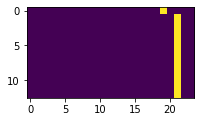

Count 200 | 예약할 수있나요~? __ => <s> => None


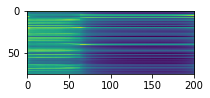

Count 400 | 할인률이 높은 제휴카드가 있나요? ____ => 어웃                     


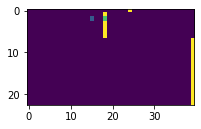

Count 400 | 할인률이 높은 제휴카드가 있나요? ____ => <s>ㅇ나요?</s> => None


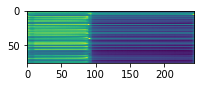

Count 600 | 할인을 가장 많이 받을 수 있는 혜택은 어떤건가요? ____ => 할인 할                             


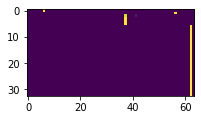

Count 600 | 할인을 가장 많이 받을 수 있는 혜택은 어떤건가요? ____ => <s>인나요?</s> => 어일                               


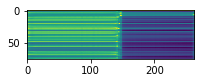

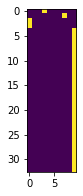

Count 800 | 런치타임이 어떻게 되나요? ___ => 런치   어어떻떻게되       


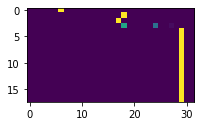

Count 800 | 런치타임이 어떻게 되나요? ___ => <s>아인가요?</s> => None


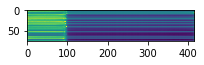

09-26 13:54:12
Mean Train Loss: 0.10189522075042962
Mean Train Seq2Seq Loss: 4.002504285717332
Train CER: 0.9943176750882289
Mean Train Reference Seq2Seq Loss: 2.9534280893405613
Train Reference CER: 0.8922468180519224
Eval Count 50 | 오후 몇 시까지 하나요? _ => 오늘 몇      나??  


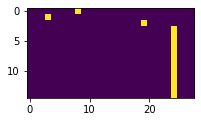

Eval Count 50 | 오후 몇 시까지 하나요? _ => <s>아인나요?</s> => None


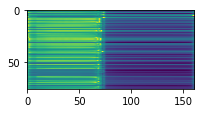

09-26 13:54:29
Mean Evaluation Loss: 0.08053191112251526
Mean Evaluation Seq2Seq Loss: 4.152405241826102
Evaluation CER: 0.9969683845820702
Mean Evaluation Reference Seq2Seq Loss: 2.711602853650847
Evaluation Reference CER: 0.8085171474898277


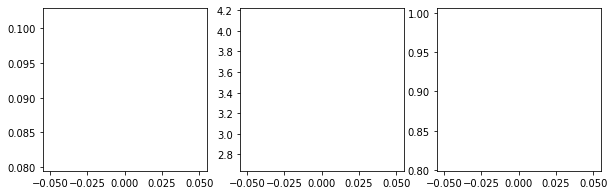

-------------------------------------------------------------------------------------------------------
09-26 13:54:30
Count 200 | 할인쿠폰 두개있는데 중복 사용가능한가요? ____ => 할인카폰폰          가가가가요요      


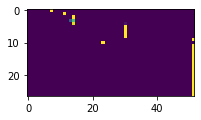

Count 200 | 할인쿠폰 두개있는데 중복 사용가능한가요? ____ => <s>아 이나요?</s> => None


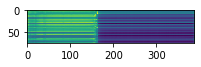

Count 400 | 몇 시 까지 영업해요? _ => 몇시까지지 영업하해요요  


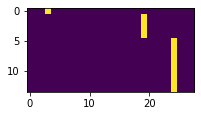

Count 400 | 몇 시 까지 영업해요? _ => <s>아 이나요?</s> => None


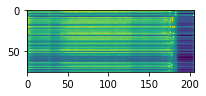

Count 600 | 포인트 카드로도 중복으로 가능한가요? __ => 이번이 플도   도 도가가가가가      


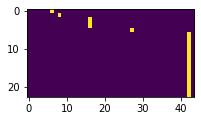

Count 600 | 포인트 카드로도 중복으로 가능한가요? __ => <s>아ㅏㅇ이나요?</s> => None


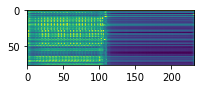

Count 800 | 안녕하세요 제가 이번주 토요일에 예약을 했는데요 예약사항을 변경하려구요 __________ => 안녕하세요                                             


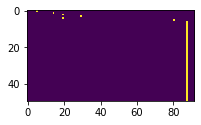

Count 800 | 안녕하세요 제가 이번주 토요일에 예약을 했는데요 예약사항을 변경하려구요 __________ => <s>아ㅏㅏ앙ㅇㅇ이이이잉잉ㅇ이이이ㅏ아아이ㅏㅏ이 이나요?</s> => 아                                                 


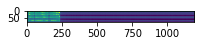

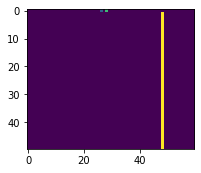

09-26 14:00:57
Mean Train Loss: 0.07140359619345574
Mean Train Seq2Seq Loss: 3.9220678400939692
Train CER: 0.9831856575432925
Mean Train Reference Seq2Seq Loss: 2.320298697851168
Train Reference CER: 0.7574018386081309
Eval Count 50 | 아웃백 브레이크 타임이 언젠가요? ____ => 아웃백       인가가가??       


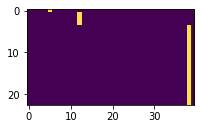

Eval Count 50 | 아웃백 브레이크 타임이 언젠가요? ____ => <s>아시이ㅣ느이나요?</s> => None


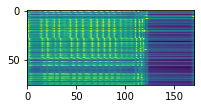

09-26 14:01:15
Mean Evaluation Loss: 0.07006444378058824
Mean Evaluation Seq2Seq Loss: 4.1566105859087985
Evaluation CER: 0.9968300929839391
Mean Evaluation Reference Seq2Seq Loss: 2.3373158638918885
Evaluation Reference CER: 0.7254806373967887


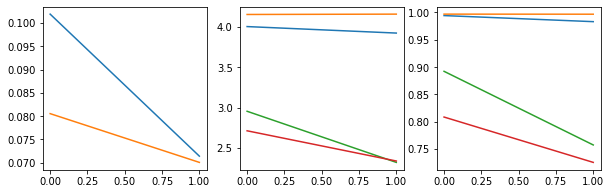

-------------------------------------------------------------------------------------------------------
09-26 14:01:15
Count 200 | 가장 많이 배달되는 음식은 무엇인가요? _____ => 가가 이      이 인인인인요?         


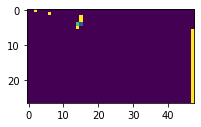

Count 200 | 가장 많이 배달되는 음식은 무엇인가요? _____ => <s>아ㅏㅇ강앙이나요?</s> => 아   요          ?  ?  ? ? ??


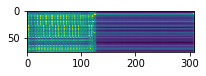

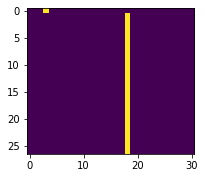

Count 400 | 위치가 대로변에 있는 것이 맞나요?  => 위치 가              나?


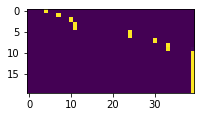

Count 400 | 위치가 대로변에 있는 것이 맞나요?  => <s>아사아ㅏㅏ시아시ㅣ으아아시 아나요?</s> => None


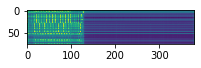

Count 600 | 설날에도 식사 가능한가요? __ => 설날에도 식사 가능한가요?   


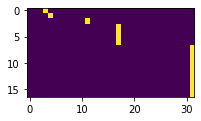

Count 600 | 설날에도 식사 가능한가요? __ => <s>자가이드시ㅏ간ㅇ하나요?</s> => None


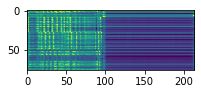

Count 800 | 이번주 목요일 낮 12시에 예약 했는데요 인원과 날짜를 변경 하고 싶은데요 ___ => 이번주 주요일  오오후 예약                              


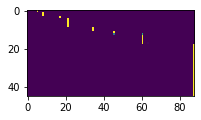

Count 800 | 이번주 목요일 낮 12시에 예약 했는데요 인원과 날짜를 변경 하고 싶은데요 ___ => <s>지가추우으가여드시약흐므에야이그ㅏ하자르 어에하시ㅜ이나요?</s> => 지금                                           


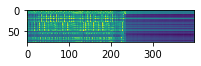

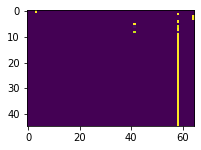

09-26 14:08:32
Mean Train Loss: 0.059347283405923906
Mean Train Seq2Seq Loss: 3.6851446950371285
Train CER: 0.9764272940204559
Mean Train Reference Seq2Seq Loss: 1.913229673915205
Train Reference CER: 0.6473339755275508
Eval Count 50 | 몇시부터 몇시까지 이용가능하나요? ___ => 몇시부터 몇시까지  능능요요??     


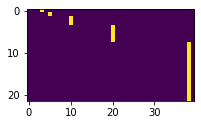

Eval Count 50 | 몇시부터 몇시까지 이용가능하나요? ___ => <s>아시가 자ㅡ시갈잉 가느ㅏ나안가요?</s> => 혹시                    


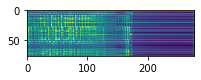

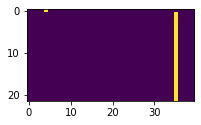

09-26 14:08:53
Mean Evaluation Loss: 0.05210780700979704
Mean Evaluation Seq2Seq Loss: 3.611406559595172
Evaluation CER: 0.9675798540495275
Mean Evaluation Reference Seq2Seq Loss: 1.926529096593105
Evaluation Reference CER: 0.6162734858034696


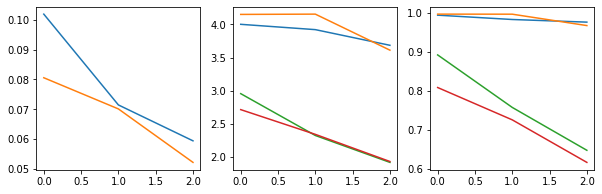

-------------------------------------------------------------------------------------------------------
09-26 14:08:53
Count 200 | 주차요원이있나요? ___ => 주차  있나나요?   ?


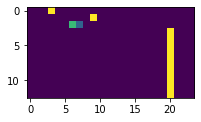

Count 200 | 주차요원이있나요? ___ => <s>주차하으 안이 있나요?</s> => None


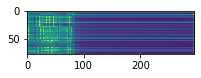

Count 400 | 주말과 주중 영업시간이 다른가요? __ => 주말 주주 영시간간  가른가??    


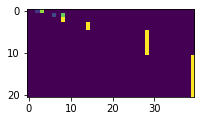

Count 400 | 주말과 주중 영업시간이 다른가요? __ => <s>주가마주든 명어시갈이그하나요?</s> => 주차장는        나요       


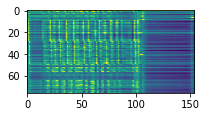

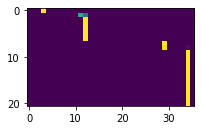

Count 600 | 안녕하세요 제가 방문 포장으로 예약을 하려고 하는데요 ____ => 안녕하세요 제   포장장     예하하하하           


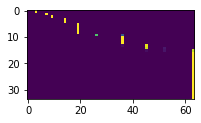

Count 600 | 안녕하세요 제가 방문 포장으로 예약을 하려고 하는데요 ____ => <s>오잉 제가장는며당하예야하려 갈느네요.</s> => 내일         하려하려하려하하려데데     요 요  요 


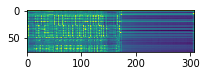

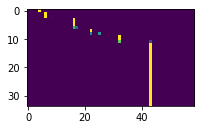

Count 800 | 파티룸 예약 가능한가요? ____ => 파리  예약 가능한가요?     


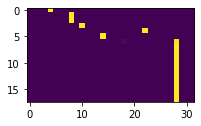

Count 800 | 파티룸 예약 가능한가요? ____ => <s>ㅇ옹하가요?</s> => 오늘  약             


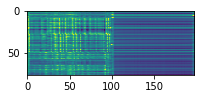

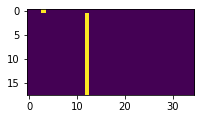

09-26 14:17:38
Mean Train Loss: 0.04291279696079869
Mean Train Seq2Seq Loss: 3.1644470825872024
Train CER: 0.8877923931020547
Mean Train Reference Seq2Seq Loss: 1.640036381642796
Train Reference CER: 0.583683200021113
Eval Count 50 | 다섯명인데 룸 이용 가능할까요? ___ => 봄 인데 룸        할할요?   


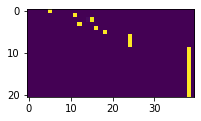

Eval Count 50 | 다섯명인데 룸 이용 가능할까요? ___ => <s>아느믕은메무영 가능할까요?</s> => 오늘           요요요     


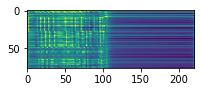

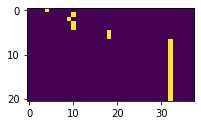

09-26 14:18:00
Mean Evaluation Loss: 0.04433832133657348
Mean Evaluation Seq2Seq Loss: 3.0911027755595017
Evaluation CER: 0.849918026944187
Mean Evaluation Reference Seq2Seq Loss: 1.7788827592713996
Evaluation Reference CER: 0.5974416626154594


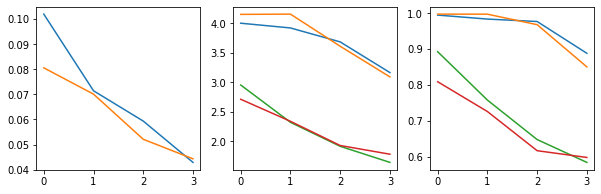

-------------------------------------------------------------------------------------------------------
09-26 14:18:01
Count 200 | 평일이랑 주말이랑 영업시간이 다른가요? _____ => 평일이랑 주말랑 영업시간이이다른른가가요?     


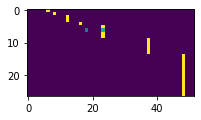

Count 200 | 평일이랑 주말이랑 영업시간이 다른가요? _____ => <s>앙이이안 주마이 아 명업시간이 가 있나요?</s> => 평일이               있있나??    


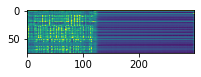

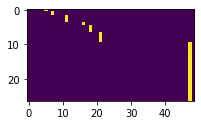

Count 400 | 인터넷 예약은 할인이 다른가요? __ => 인터넷 예약  인  다른가요?    


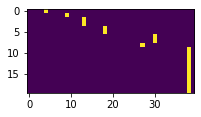

Count 400 | 인터넷 예약은 할인이 다른가요? __ => <s>이정이예야이 가ㅣ 잘인가요?</s> => 이일 예약이        ??    


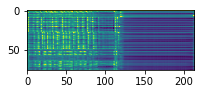

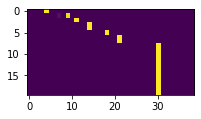

Count 600 | 가까운 주차장이 어디있나요? _ => 가까운 주차장이이이 있있요?  


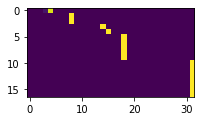

Count 600 | 가까운 주차장이 어디있나요? _ => <s>아타 주서할이어이 있나요?</s> => 아아      이  있요요?  


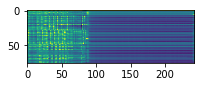

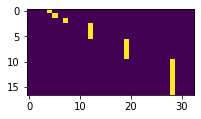

Count 800 | 차타고 가고 있는데 신세계백화점 맞은편 대로에서 어느 골목으로 들어가야하나요? ______ => 차차타고 고 있는데  식 점                                   


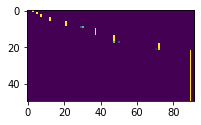

Count 800 | 차타고 가고 있는데 신세계백화점 맞은편 대로에서 어느 골목으로 들어가야하나요? ______ => <s>자차ㅏ고가고있는데 ㅐㅔ개엡가잠 가느겨에우서 어나고모ㅡ로ㅗ 드러가하나요?</s> => 주차하가고 가는데데 백백                                     


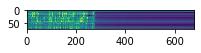

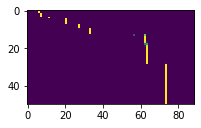

09-26 14:26:51
Mean Train Loss: 0.03593083499288879
Mean Train Seq2Seq Loss: 2.753651059666169
Train CER: 0.7818945572091954
Mean Train Reference Seq2Seq Loss: 1.448498804750046
Train Reference CER: 0.5255464040152658
Eval Count 50 | 20명 예약 가능한가요?  => 20명 예약 가능한가요? 


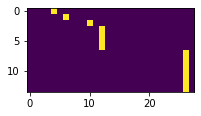

Eval Count 50 | 20명 예약 가능한가요?  => <s>자ㅜ면 예약 가능한가요?</s> => 주명 예약약 가능한가요? 


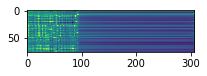

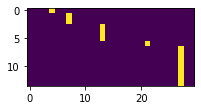

09-26 14:27:13
Mean Evaluation Loss: 0.03405771281987038
Mean Evaluation Seq2Seq Loss: 2.7612104537592335
Evaluation CER: 0.7595342344057364
Mean Evaluation Reference Seq2Seq Loss: 1.6288071975771272
Evaluation Reference CER: 0.5475530651399336


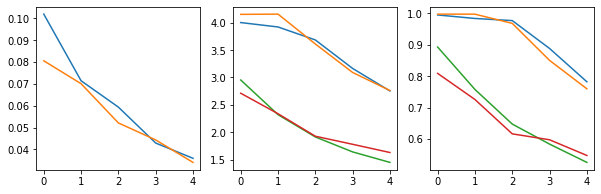

-------------------------------------------------------------------------------------------------------
09-26 14:27:14
Count 200 | 혹시 대학생 할인 이벤트 진행 중인가요? _____ => 혹시 배달 할할인  벤 중중중인가          


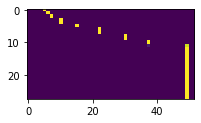

Count 200 | 혹시 대학생 할인 이벤트 진행 중인가요? _____ => <s>혹시 작승 할이이므느주으 주인가요?</s> => 혹시 생         중중 요요요         


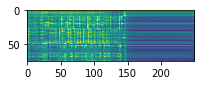

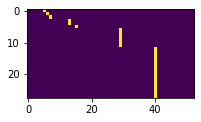

Count 400 | 샐러드 종류는 몇 가지가 있나요? __ => 샐러드 종류는    가가 가가  있  


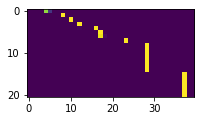

Count 400 | 샐러드 종류는 몇 가지가 있나요? __ => <s>샐자르당 뮤는 몇까지가 있나요?</s> => 매장카드  는는  몇까지지지  있나요 


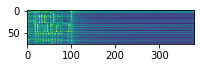

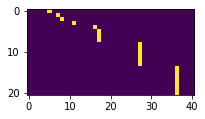

Count 600 | 영업시간이 어떻게 되나요? ___ => 영업시간이 어떻게 되나요?    


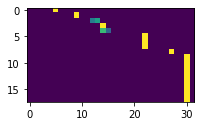

Count 600 | 영업시간이 어떻게 되나요? ___ => <s>옹헙시간이 어떻게 되나요?</s> => 영업시시이 어떻게 되나요?    


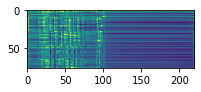

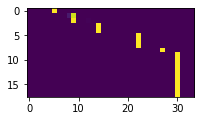

Count 800 | 구운 통감자 구운 통고구마 추가해 주시고요 골드 코스트 코코넛 쉬림프도 보내주세요 ____ => 구후  가   골   고 고                           요요 요요요요요


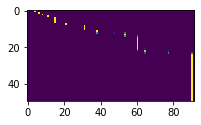

Count 800 | 구운 통감자 구운 통고구마 추가해 주시고요 골드 코스트 코코넛 쉬림프도 보내주세요 ____ => <s>구모 폰사다 고운도 고구가수강주시그요 어드코트ㅓ프으 시 포뎌고래주세요</s> => 부러  동동          놓              찾 찾찾찾찾찾찾      요요요요요


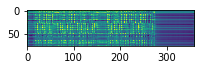

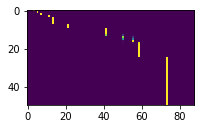

09-26 14:36:21
Mean Train Loss: 0.03000262491096117
Mean Train Seq2Seq Loss: 2.481576614204113
Train CER: 0.7199681174714011
Mean Train Reference Seq2Seq Loss: 1.3167739195164607
Train Reference CER: 0.49126747490137873
Eval Count 50 | 아웃백 아침 브레이크 타임 있나요? _ => 아웃백 침침 브이크타임임 있나나    


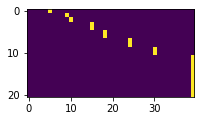

Eval Count 50 | 아웃백 아침 브레이크 타임 있나요? _ => <s>다웃백 가트브이크타이이 있나요?</s> => 아웃백  레이크타타  있        


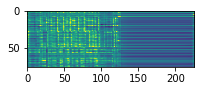

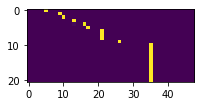

09-26 14:36:44
Mean Evaluation Loss: 0.030231852601380064
Mean Evaluation Seq2Seq Loss: 2.6166230853173653
Evaluation CER: 0.7343530513500859
Mean Evaluation Reference Seq2Seq Loss: 1.5522151937648194
Evaluation Reference CER: 0.5452443254427067


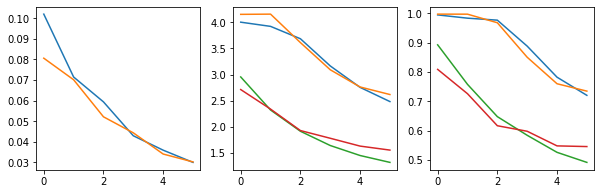

-------------------------------------------------------------------------------------------------------
09-26 14:36:45
Count 200 | 이번주 일요일 12시쯤 자리 예약 되나요? __ => 이번주 토요일 1시시   예예약약 나나나??  


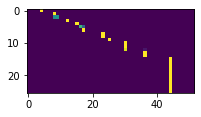

Count 200 | 이번주 일요일 12시쯤 자리 예약 되나요? __ => <s>입ㄴ주일일**ㅡ시쯤자이약되나요?</s> => 주요일          약약약 되??      


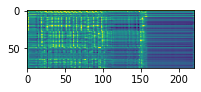

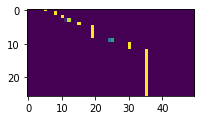

Count 400 | 차가운 음식이 있나요? __ => 가간  식이 있나요?   요


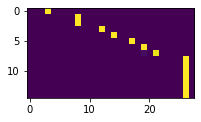

Count 400 | 차가운 음식이 있나요? __ => <s>자ㅏ가하는 시드 있나요?</s> => 주장 가능    있있    


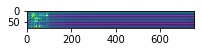

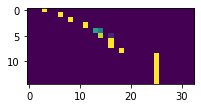

Count 600 | 죄송한데 예약 취소할 수 있을까요? ______ => 죄송한데 예약 취소할 수 있을까?        


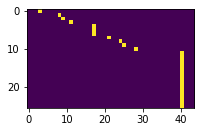

Count 600 | 죄송한데 예약 취소할 수 있을까요? ______ => <s>주소한데 예약 취소할 숬을까요?</s> => 죄송한데 예예약 취할               


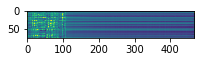

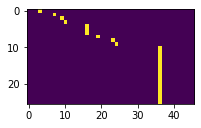

Count 800 | 감사합니다 그러면 지난주에 식사 했던 내역도 포인트 적립이 가능한가요? ____ => 감사합니             가   ?    ??  ??   요요나나나나나나요


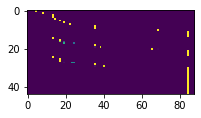

Count 800 | 감사합니다 그러면 지난주에 식사 했던 내역도 포인트 적립이 가능한가요? ____ => <s>가마에다여하드식살보에여보하으비서이이 가능한가요?</s> => 감가                                          


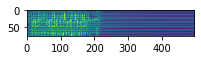

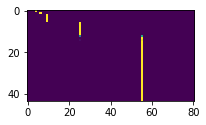

09-26 14:45:49
Mean Train Loss: 0.02613361707317562
Mean Train Seq2Seq Loss: 2.330935931956082
Train CER: 0.6793637458468977
Mean Train Reference Seq2Seq Loss: 1.2432521964802716
Train Reference CER: 0.46909852787120254
Eval Count 50 | 볶음밥 고수 들어가요? ___ => 오               


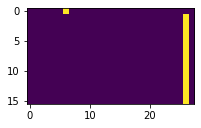

Eval Count 50 | 볶음밥 고수 들어가요? ___ => <s>오픈가고소스되나요?</s> => 오               


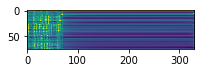

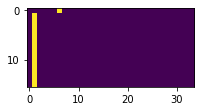

09-26 14:46:12
Mean Evaluation Loss: 0.027078548982819927
Mean Evaluation Seq2Seq Loss: 3.774444580147385
Evaluation CER: 0.9727675164097085
Mean Evaluation Reference Seq2Seq Loss: 3.5692102995288533
Evaluation Reference CER: 0.9557083658639121


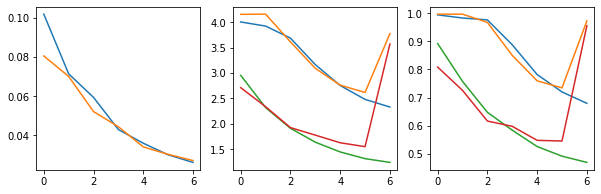

-------------------------------------------------------------------------------------------------------
09-26 14:46:13
Count 200 | 아웃백 근처에 가까운 버스 정류장이 있나요? ___ => 아웃백                      ?  


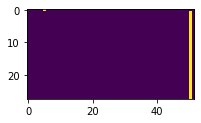

Count 200 | 아웃백 근처에 가까운 버스 정류장이 있나요? ___ => <s>아웃백 근체에 포따 안 벗사엘알이 이나요?</s> => 아웃백                  나 요   요


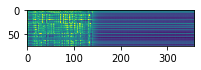

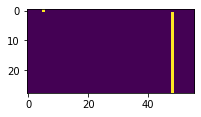

Count 400 | 발레 파킹 가능한가요? __ => 발레파킹 가능가가능가?? ?


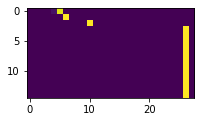

Count 400 | 발레 파킹 가능한가요? __ => <s>매가이 다딨나요?</s> => None


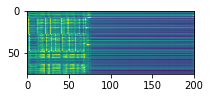

Count 600 | 차로가는데 무슨도로를 타고 가야하나요? __ => 차로               나나요나요  


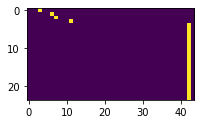

Count 600 | 차로가는데 무슨도로를 타고 가야하나요? __ => <s>아가느데 브서고모르자느하르느가요?</s> => 아금                      


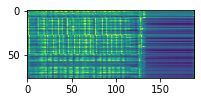

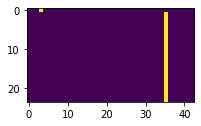

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? ______ => 혹시                                               


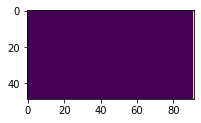

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? ______ => <s>아가문텡드바이 카으잉지에는 ㅔ 자차인머마ㅏㄴ 밫이 투가고 가이 가능ㅎ요</s> => 아웃                                               


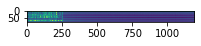

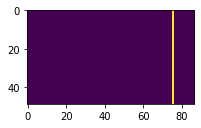

09-26 14:54:14
Mean Train Loss: 0.04680061441660635
Mean Train Seq2Seq Loss: 3.4446339646460227
Train CER: 0.943415989538089
Mean Train Reference Seq2Seq Loss: 2.604528668592574
Train Reference CER: 0.8228078804753581
Eval Count 50 | 미리 주문 가능한 메뉴가 있나요? ___ => 지기                    


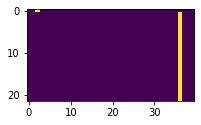

Eval Count 50 | 미리 주문 가능한 메뉴가 있나요? ___ => <s>여니 주만가능한데뉴가인있나요?</s> => 아기                    


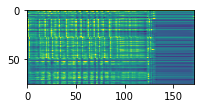

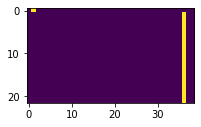

09-26 14:54:37
Mean Evaluation Loss: 0.047330546768923815
Mean Evaluation Seq2Seq Loss: 3.6433197613676946
Evaluation CER: 0.9824136757308725
Mean Evaluation Reference Seq2Seq Loss: 3.1389940734178072
Evaluation Reference CER: 0.9503158406219631


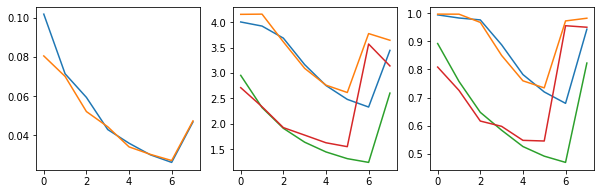

-------------------------------------------------------------------------------------------------------
09-26 14:54:37
Count 200 | 오늘 예약 되나요? __ => 오늘           


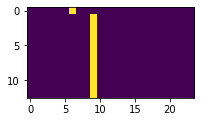

Count 200 | 오늘 예약 되나요? __ => <s>여ㅔ이약 드데요?</s> => None


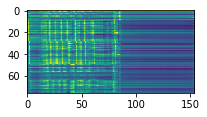

Count 400 | 그렇게 해주시면 감사하겠습니다 ____ => 그렇렇매합                


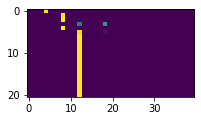

Count 400 | 그렇게 해주시면 감사하겠습니다 ____ => <s>지ㅑ기이두시여ㅓㄴ 간자할이 숩니다.</s> => 아일                   


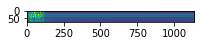

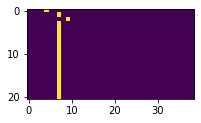

Count 600 | 영업시간이 인터넷에 나와있는시간이랑  왜 다른거죠~? ____ => 영업                                


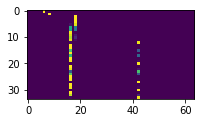

Count 600 | 영업시간이 인터넷에 나와있는시간이랑  왜 다른거죠~? ____ => <s>앙ㅂ시간잉 이버레서 마히느 지간이ㅏ론 거가ㅡㅏ요?</s> => 통시간                         요  ?  


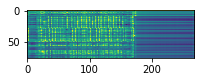

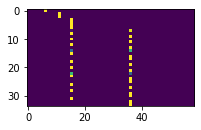

Count 800 | 마감 시간이 어떻게 되나요? _ => 생                


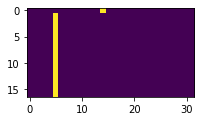

Count 800 | 마감 시간이 어떻게 되나요? _ => <s>아간시간여어떻게되나요?</s> => 안                


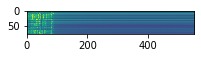

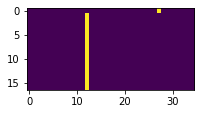

09-26 15:03:18
Mean Train Loss: 0.04299322794396672
Mean Train Seq2Seq Loss: 3.5796352441125934
Train CER: 0.9613410530088813
Mean Train Reference Seq2Seq Loss: 3.0663995531170434
Train Reference CER: 0.9082900711682763
Eval Count 50 | 잃어버린 물건 찾으러 전화했어요 ___ => 아                    


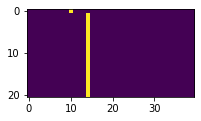

Eval Count 50 | 잃어버린 물건 찾으러 전화했어요 ___ => <s>ㅇ약어린늘건 자즈러전할서요?</s> => 아                    


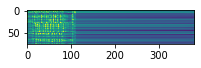

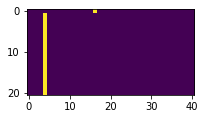

09-26 15:03:40
Mean Evaluation Loss: 0.039813612390833614
Mean Evaluation Seq2Seq Loss: 3.7129706421841693
Evaluation CER: 0.9864073119287555
Mean Evaluation Reference Seq2Seq Loss: 3.5032288145969472
Evaluation Reference CER: 0.9815309031358039


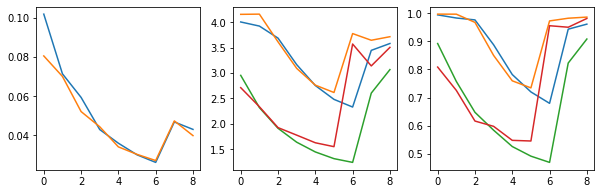

-------------------------------------------------------------------------------------------------------
09-26 15:03:40
Count 200 | 여자친구와 먹기 좋은 메뉴 좀 추천해주세요 ____ => 주차   주주주주주주       요    요   요


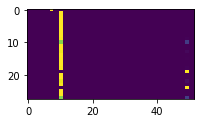

Count 200 | 여자친구와 먹기 좋은 메뉴 좀 추천해주세요 ____ => <s>ㅇㅊ서 시무어 어배 조ㅗㄴ메 뉴줌주차하해수세요</s> => 몇시                        ? 


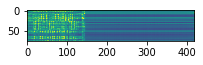

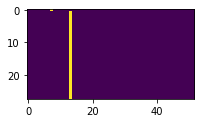

Count 400 | 이번 주 토요일에 예약 가능할까요 __ => 이번 토               요요


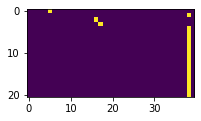

Count 400 | 이번 주 토요일에 예약 가능할까요 __ => <s>여번지 조요이데 *ㅣ약 가능할까요?</s> => 안번                요요 


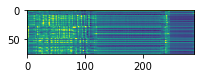

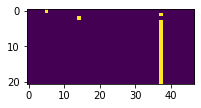

Count 600 | 네 예약하려고 전화했어요 ___ => 네  약  하  했       


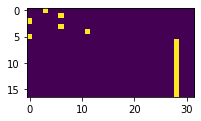

Count 600 | 네 예약하려고 전화했어요 ___ => <s>오ㅣ 예약 하고선하서요?</s> => 오일 예약  약         


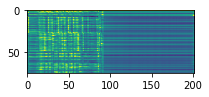

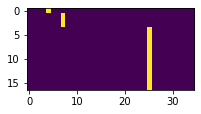

Count 800 | 초보라 주차가 서툰데 혹시 발레 파킹도 되나요? 저녁에 가려는데 발레파킹 되는지요? ___ => 구로                                                


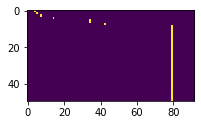

Count 800 | 초보라 주차가 서툰데 혹시 발레 파킹도 되나요? 저녁에 가려는데 발레파킹 되는지요? ___ => <s>아움서보라 ㅜ차하서댄자 옥시 타요버키대 주나 잔가에 하료느자ㅣ 카라바이재니시요ㅏ?</s> => 그금 쿠     백 백      백                               


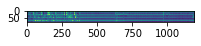

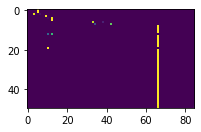

09-26 15:12:36
Mean Train Loss: 0.037945353820105915
Mean Train Seq2Seq Loss: 3.1273075109564012
Train CER: 0.8777521586711526
Mean Train Reference Seq2Seq Loss: 2.4128149845936724
Train Reference CER: 0.777639100317179
Eval Count 50 | 네 그럼 제가 다시 연락은 안드려도 되는 거죠? ___ => 예약약???????????????????????로?로?


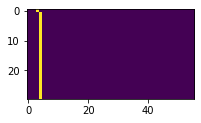

Eval Count 50 | 네 그럼 제가 다시 연락은 안드려도 되는 거죠? ___ => <s>오 갈ㅇㅁ 차가 파신으 악가한데러 보 게능 거죠?</s> => 예약약???????????????????????????


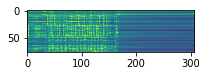

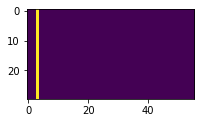

09-26 15:12:59
Mean Evaluation Loss: 0.03745244447223788
Mean Evaluation Seq2Seq Loss: 4.6560106754993855
Evaluation CER: 1.1983285435866944
Mean Evaluation Reference Seq2Seq Loss: 4.357268782793755
Evaluation Reference CER: 1.1888750644857828


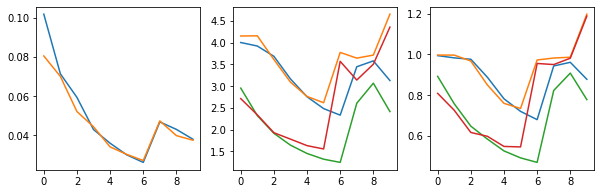

-------------------------------------------------------------------------------------------------------
09-26 15:12:59
Count 200 | 지금 제일 할인률이 높은 카드가 뭔가요? _____ => 지금                          


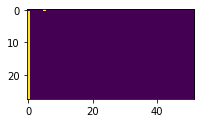

Count 200 | 지금 제일 할인률이 높은 카드가 뭔가요? _____ => <s>조븜치하이이되노푼가으서펀나요?</s> => 런치                     ?   ?


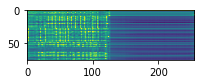

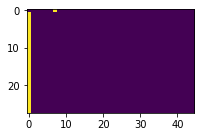

Count 400 | 할인받을 수 있는 카드 있나요? ____ => 할인                  ? 


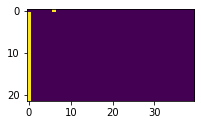

Count 400 | 할인받을 수 있는 카드 있나요? ____ => <s>중바을수는 카딨나요?</s> => 주말                 ?  


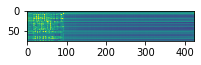

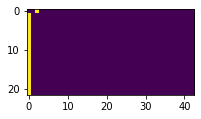

Count 600 | 영업시간 언제부터인가요 ____ => 영업시간이        요요  


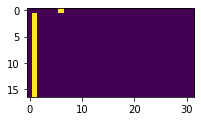

Count 600 | 영업시간 언제부터인가요 ____ => <s>영업시강 언지수터리ㅣㄴ가요?</s> => 영업시간간            


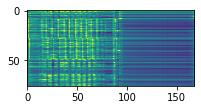

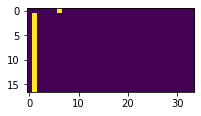

Count 800 | 아 네 혹시 그때 그 2월에 출시되는 양갈비스테이크 코스를 먹을 수 있을까요? _ => 아 그                                          


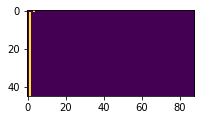

Count 800 | 아 네 혹시 그때 그 2월에 출시되는 양갈비스테이크 코스를 먹을 수 있을까요? _ => <s>아 며시ㅡ테크이 주시간 면가 메시테이커 주거먹어수 있을까요?</s> => 아                                            


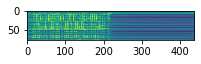

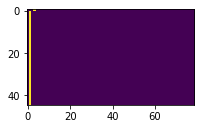

09-26 15:21:54
Mean Train Loss: 0.03532855321173792
Mean Train Seq2Seq Loss: 3.1345086865099967
Train CER: 0.8923142716361574
Mean Train Reference Seq2Seq Loss: 2.667669904545117
Train Reference CER: 0.826939398147842
Eval Count 50 | 생일 할인은 몇 명까지 되나요? _____ => 생일할인인  몇     ??      ? 


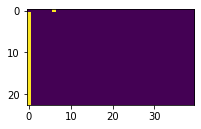

Eval Count 50 | 생일 할인은 몇 명까지 되나요? _____ => <s>장일 할인이 몇명까지 되나요?</s> => 생일 할인이 몇     ??    ?   


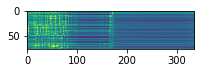

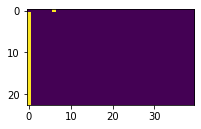

09-26 15:22:17
Mean Evaluation Loss: 0.034210087776064685
Mean Evaluation Seq2Seq Loss: 2.937685500633663
Evaluation CER: 0.7723777203524393
Mean Evaluation Reference Seq2Seq Loss: 2.344703662286928
Evaluation Reference CER: 0.6782590525090301


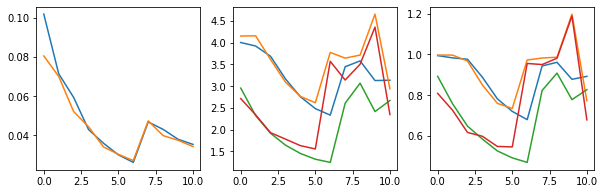

-------------------------------------------------------------------------------------------------------
09-26 15:22:17
Count 200 | 일요일에도 영업을 하시나요? ___ => 일일일에도 영업하시시        


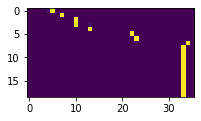

Count 200 | 일요일에도 영업을 하시나요? ___ => <s>이일ㅇ 저영업매 가시나요?</s> => 일일 영 영업하하  나나  요요  


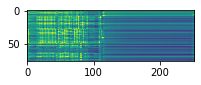

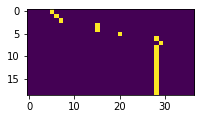

Count 400 | 오후 2시에 가능한가요? _ => 오후 시시에 가능한가요?  


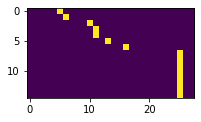

Count 400 | 오후 2시에 가능한가요? _ => <s>오 두시 가능한가요?</s> => 오후 통능능한가요요     


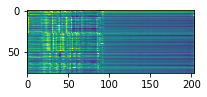

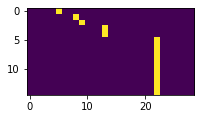

Count 600 | 단체 20명이 같이 앉을 수 있는 자리 예약 가능한가요? __ => 단체 2명명 이               ?  ?   ?   


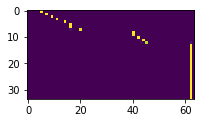

Count 600 | 단체 20명이 같이 앉을 수 있는 자리 예약 가능한가요? __ => <s>안체 저벙이가잕데숬느 사리 예약 가능한가요?</s> => 단체  장명 할             능한           


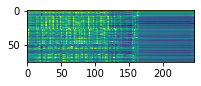

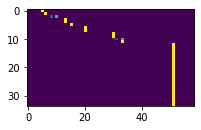

Count 800 | skt gold회원은 할인이 얼마나 되죠? __ => s    한    마되되 되  ?되죠? ?? ?


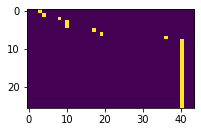

Count 800 | skt gold회원은 할인이 얼마나 되죠? __ => <s>주*ㅣ콩 크느은 아ㅏㄹ인 영ㅇㄴ 마갇죠?</s> => s차                        


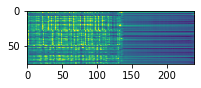

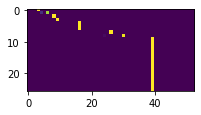

09-26 15:31:15
Mean Train Loss: 0.03378995816847768
Mean Train Seq2Seq Loss: 2.8961418040554734
Train CER: 0.8171660030522439
Mean Train Reference Seq2Seq Loss: 1.9626846371338265
Train Reference CER: 0.6631411242473519
Eval Count 50 | 배달료를 따로 받나요? __ => 배달밀      받나나나요?


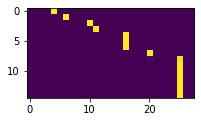

Eval Count 50 | 배달료를 따로 받나요? __ => <s>지달이으 따로 갇나요?</s> => 주달 크       나요요 


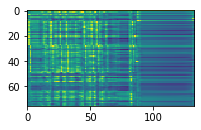

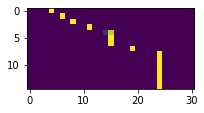

09-26 15:31:38
Mean Evaluation Loss: 0.03466265345100967
Mean Evaluation Seq2Seq Loss: 3.1053427595686736
Evaluation CER: 0.841095108178415
Mean Evaluation Reference Seq2Seq Loss: 2.4138581751945276
Evaluation Reference CER: 0.7460302974995437


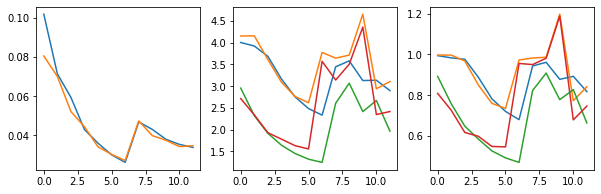

-------------------------------------------------------------------------------------------------------
09-26 15:31:38
Count 200 | 토요일 12시에 예약 가능한가요?  => 토일일1              요


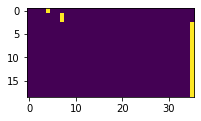

Count 200 | 토요일 12시에 예약 가능한가요?  => <s>호ㅣ에*ㅔ시에 예약 가능한가요?</s> => 오늘 예약 예약 예약  약  능? 


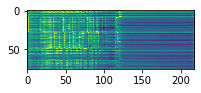

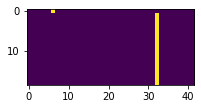

Count 400 | 주차 공간 부족시 다른 주차장에 주차 가능한가요? _ => 주차  차  차 차 차 차 차 차  차       요


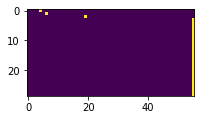

Count 400 | 주차 공간 부족시 다른 주차장에 주차 가능한가요? _ => <s>주처간프조시 달ㄴ 주차장에 주차ㅏ 가능한가요?</s> => 주차  차  차 주차 주차  차  요요  요?   ?


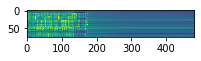

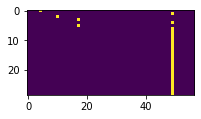

Count 600 | 오픈시간이 어떻게 되나요? _ => 오픈시간이 어떻떻 되나요?  


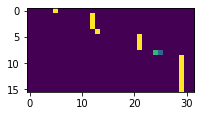

Count 600 | 오픈시간이 어떻게 되나요? _ => <s>주체시간이 어어떻게 되나요?</s> => 주차시간간  어떻게 되나요? 


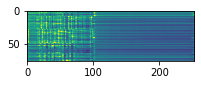

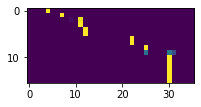

Count 800 | 생선을 이용한 스테이크 류도 파나요? __ => 상문은 용                  


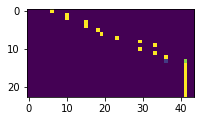

Count 800 | 생선을 이용한 스테이크 류도 파나요? __ => <s>주소에 쥬랸 하이크되 도 다나요?</s> => 주차에                    


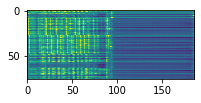

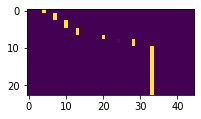

09-26 15:40:38
Mean Train Loss: 0.03233340666036548
Mean Train Seq2Seq Loss: 2.8902160832889545
Train CER: 0.8277799284949787
Mean Train Reference Seq2Seq Loss: 2.1829057534956733
Train Reference CER: 0.7227366040552854
Eval Count 50 | 체인점 어디어디 있나요? _ => 할치  어어 어  나요?  


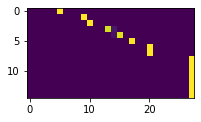

Eval Count 50 | 체인점 어디어디 있나요? _ => <s>지이지 머젝 있나요?</s> => 생요         나요  


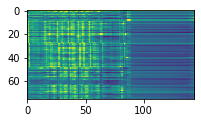

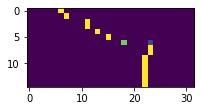

09-26 15:41:01
Mean Evaluation Loss: 0.032851639915908754
Mean Evaluation Seq2Seq Loss: 2.827855133037082
Evaluation CER: 0.7925907097922095
Mean Evaluation Reference Seq2Seq Loss: 1.858180208470988
Evaluation Reference CER: 0.6187277755827736


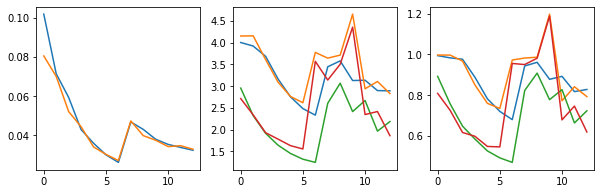

-------------------------------------------------------------------------------------------------------
09-26 15:41:02
Count 200 | 아웃백의 특정메뉴 지금 파는지 궁금합니다 ____ => 아웃백                        


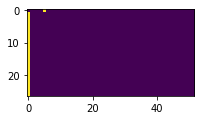

Count 200 | 아웃백의 특정메뉴 지금 파는지 궁금합니다 ____ => <s>아웃백에부처세뉼시간 바엔주 구금합니다.</s> => 아웃백                        


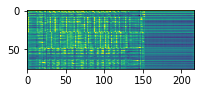

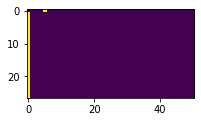

Count 400 | 배달 했을 경우 맛은 같은가요? ___ => 배달                   


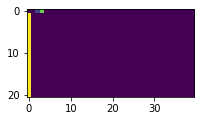

Count 400 | 배달 했을 경우 맛은 같은가요? ___ => <s>매댈시쯔오 마신 가든가요?</s> => 배달             ?  ?  


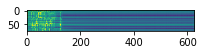

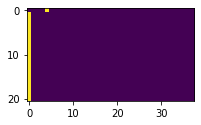

Count 600 | sk통신사 할인은 몇%에요? __ => sk통시인         ?  ?


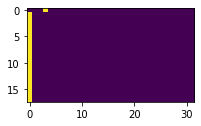

Count 600 | sk통신사 할인은 몇%에요? __ => <s>애스이도시사 할인인 몇프레요?</s> => 내일              ? 


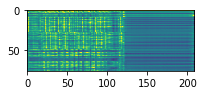

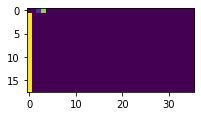

Count 800 | 저희 반 애들이 다 갈거라 한 30명이 갈것 같은데 졸업식날 단체예약 되나요? ______ => 저희                                                


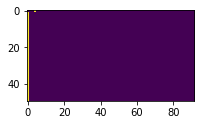

Count 800 | 저희 반 애들이 다 갈거라 한 30명이 갈것 같은데 졸업식날 단체예약 되나요? ______ => <s>하이이마으드리다할고아 산던서막이날고같은데추오순만 단체해약되나요?</s> => 아이               데  데  데  데                       


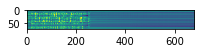

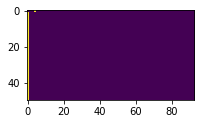

09-26 15:50:05
Mean Train Loss: 0.03138545520492081
Mean Train Seq2Seq Loss: 3.1947275192784614
Train CER: 0.9093218466975922
Mean Train Reference Seq2Seq Loss: 2.8489600977484675
Train Reference CER: 0.8636047885033845
Eval Count 50 | 어린이 할인이 있나요? ___ => 어린이 할    ?  ? ? 


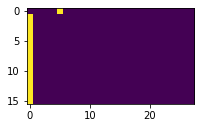

Eval Count 50 | 어린이 할인이 있나요? ___ => <s>아린이 할인이 있나요?</s> => 할인       ? ? ? ?


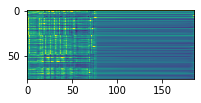

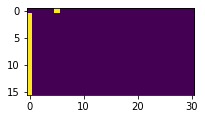

09-26 15:50:28
Mean Evaluation Loss: 0.03204820450343866
Mean Evaluation Seq2Seq Loss: 3.0162103568132967
Evaluation CER: 0.8459096766083158
Mean Evaluation Reference Seq2Seq Loss: 2.5013892906347777
Evaluation Reference CER: 0.7951462806398637


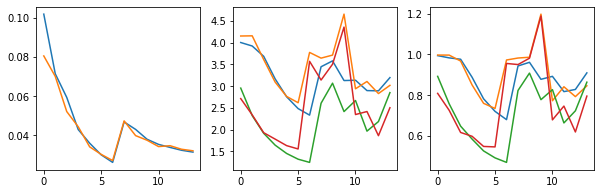

-------------------------------------------------------------------------------------------------------
09-26 15:50:28
Count 200 | 세화빌딩 601호로 배달해 주세요  => 네                  


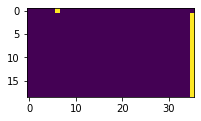

Count 200 | 세화빌딩 601호로 배달해 주세요  => <s>새아에도느때유오로 배달수세요</s> => 샐러                 


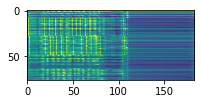

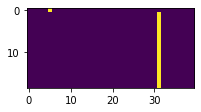

Count 400 | 아 아니다 혹시 제가 방문해서 포장해도 될까요? ___ => 아                             


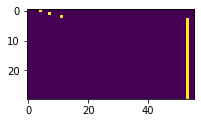

Count 400 | 아 아니다 혹시 제가 방문해서 포장해도 될까요? ___ => <s>아 어기다 모시수나 포믄느서  ㅗ자주조주ㅣ까요ㅛ?</s> => 아                        ?    


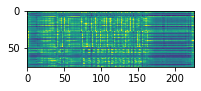

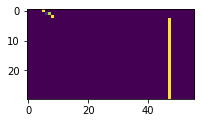

Count 600 | 일요일 2시로 변경되나요? _ => 일일일             


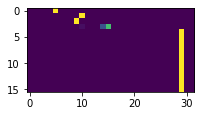

Count 600 | 일요일 2시로 변경되나요? _ => <s>이사로이따시르한느 듵나요?</s> => 이               


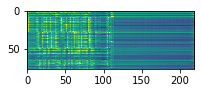

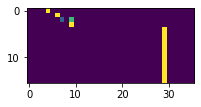

Count 800 | 지금 가려고 하는데 예약하고 가야하나요? ___ => 지금 가려고     하 하하하 하        


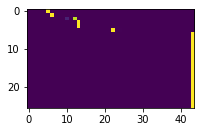

Count 800 | 지금 가려고 하는데 예약하고 가야하나요? ___ => <s>지금 가려고 하 한뎅 ㅇㄱ 하고 하ㅑ 핮요?</s> => 지금 가고  고    하 하 하         


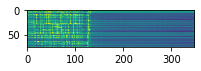

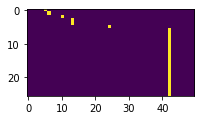

09-26 15:59:33
Mean Train Loss: 0.030612052520930126
Mean Train Seq2Seq Loss: 2.845855624043107
Train CER: 0.8300858771739915
Mean Train Reference Seq2Seq Loss: 2.2606398109114094
Train Reference CER: 0.7476066163614411
Eval Count 50 | 주차비 할인 해주시나요? _ => 주차비할     나요??  


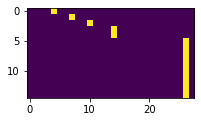

Eval Count 50 | 주차비 할인 해주시나요? _ => <s>주차비 할인되 주쇠나요?</s> => 주차비할     나나요?  


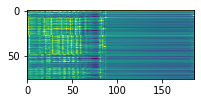

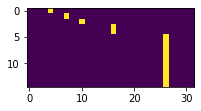

09-26 15:59:56
Mean Evaluation Loss: 0.03120880380975135
Mean Evaluation Seq2Seq Loss: 2.7333785982632226
Evaluation CER: 0.7428715778837349
Mean Evaluation Reference Seq2Seq Loss: 1.9634861361641438
Evaluation Reference CER: 0.6268656716417911


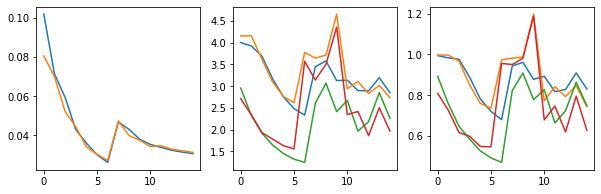

-------------------------------------------------------------------------------------------------------
09-26 15:59:56
Count 200 | 아기용 식기가 매장에 따로 준비되어 있나요? _ => 아기의의                  ?  요


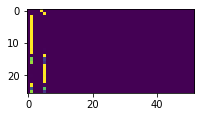

Count 200 | 아기용 식기가 매장에 따로 준비되어 있나요? _ => <s>아기 호시키가 메장 이다로 주이되어 있나요?</s> => 아기                   요  요 


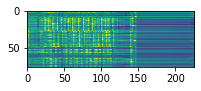

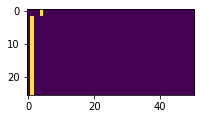

Count 400 | 추석에 영업 안하나요? __ => 추석에 영업 하요 ?  ? 


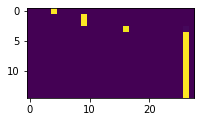

Count 400 | 추석에 영업 안하나요? __ => <s>지조에영업하나나요?</s> => 설석  영업하 ?? ????


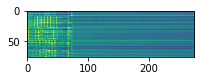

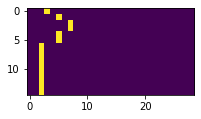

Count 600 | 다음 주에 영업 안하는 날이 있나요? __ => 다음       나 나 나 나 나?나 ? 


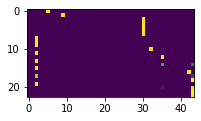

Count 600 | 다음 주에 영업 안하는 날이 있나요? __ => <s>잠치이여어아하는하이있나요?</s> => 잠치                     


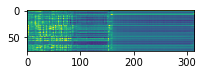

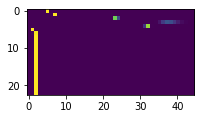

Count 800 | 아이가 먹을 수 있는 부드럽고 저자극적인 메뉴가 있으면 좋겠는데 혹시 있나요? ______ => 혹                                                 


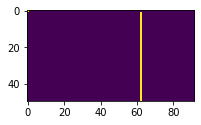

Count 800 | 아이가 먹을 수 있는 부드럽고 저자극적인 메뉴가 있으면 좋겠는데 혹시 있나요? ______ => <s>아로고시문ㅌㅅ포 차사 즈리메더수이슸는데ㅗ시있나요?</s> => 혹                                                 


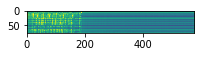

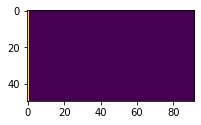

09-26 16:09:12
Mean Train Loss: 0.030035963236175026
Mean Train Seq2Seq Loss: 3.236098996571572
Train CER: 0.919845792449225
Mean Train Reference Seq2Seq Loss: 2.8990553963934373
Train Reference CER: 0.8788555012069205
Eval Count 50 | 2살 아기가 있는데 자리에 아기의자 주실 수 있나요? _ => 1기                             


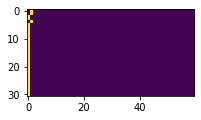

Eval Count 50 | 2살 아기가 있는데 자리에 아기의자 주실 수 있나요? _ => <s>아사아기갔는데 다링 아기의자ㅏ줄수 있나요?</s> => 아기                             


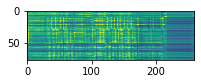

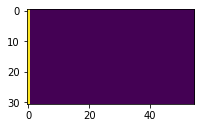

09-26 16:09:35
Mean Evaluation Loss: 0.03094003469100956
Mean Evaluation Seq2Seq Loss: 3.4044544402670396
Evaluation CER: 0.9686576909921956
Mean Evaluation Reference Seq2Seq Loss: 3.1881002207892983
Evaluation Reference CER: 0.9520805167492865


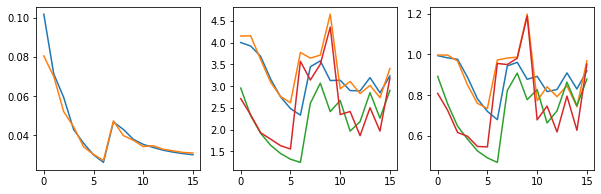

-------------------------------------------------------------------------------------------------------
09-26 16:09:36
Count 200 | 오목교에서 내려 걸어가면 몇 분 정도 걸려요?  => 오늘                        


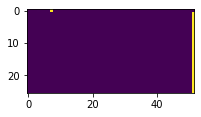

Count 200 | 오목교에서 내려 걸어가면 몇 분 정도 걸려요?  => <s>오 그이서애고로하명소브령ㅇ가ㅕ?</s> => 아늘                        


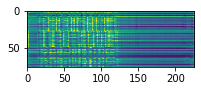

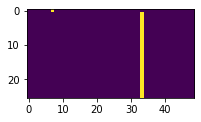

Count 400 | 가까운 버스 정류장이 어디인가요? __ => 가가         디가가       


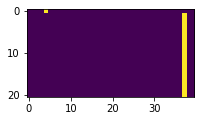

Count 400 | 가까운 버스 정류장이 어디인가요? __ => <s>아까ㅜㄴ더스살이장에 어드어가요?</s> => 할인                  ?


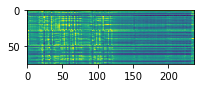

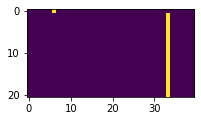

Count 600 | 스테이크는 꼭 시켜야 되나요?  => 스테이크             


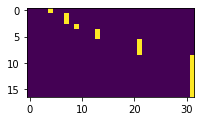

Count 600 | 스테이크는 꼭 시켜야 되나요?  => <s>배이크릉각추섿ㅈ요?</s> => 스테이크       요요   ?


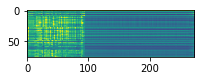

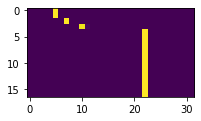

Count 800 | 아웃백에서 학생 할인이 되는지 궁금합니다 무엇을 어떻게 물어보실 건가요? ______ => 아웃백에 에에                                        


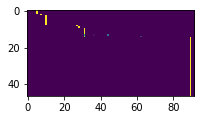

Count 800 | 아웃백에서 학생 할인이 되는지 궁금합니다 무엇을 어떻게 물어보실 건가요? ______ => <s>아웃백에 저가생한이이 멘 주무구가뎌 므머ㅓ제 어떻게가고려 간나요?</s> => 아웃백에 백에                                        


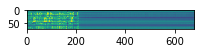

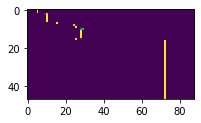

09-26 16:18:41
Mean Train Loss: 0.030515704222949323
Mean Train Seq2Seq Loss: 2.8624610973193665
Train CER: 0.8310349306448218
Mean Train Reference Seq2Seq Loss: 2.2312388532048213
Train Reference CER: 0.735181965095856
Eval Count 50 | 오늘 예약가능한가요? ___ => 오늘 예약 가가능가가요?  


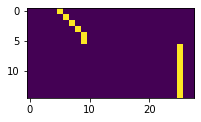

Eval Count 50 | 오늘 예약가능한가요? ___ => <s>어늘 예약 가능한가요?</s> => 오늘 예약  가능한가가?  


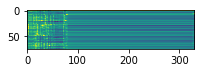

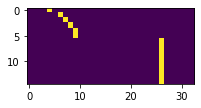

09-26 16:19:04
Mean Evaluation Loss: 0.031962617264233675
Mean Evaluation Seq2Seq Loss: 2.8491897693847856
Evaluation CER: 0.7746912569201035
Mean Evaluation Reference Seq2Seq Loss: 2.2313082318130677
Evaluation Reference CER: 0.663776762686057


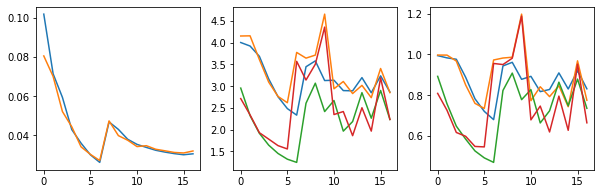

-------------------------------------------------------------------------------------------------------
09-26 16:19:04
Count 200 | 비건 메뉴 있나요? __ => 아기           


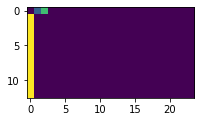

Count 200 | 비건 메뉴 있나요? __ => <s>지간 메이 있나요?</s> => 생일          있


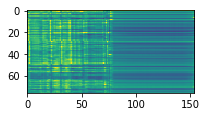

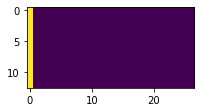

Count 400 | 평일 영업 시간이 어떻게 되나요? _ => 평일             나요?  


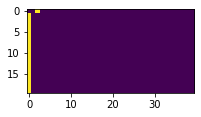

Count 400 | 평일 영업 시간이 어떻게 되나요? _ => <s>생일ㅇㅇ업시간이 어떻게 되나요?</s> => 생일 할인         나요?   


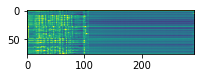

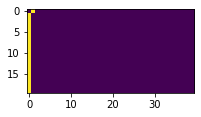

Count 600 | 4호선 쌍문역 쪽인데 대중교통으로 가는 방법 있나요? ____ => b월                                


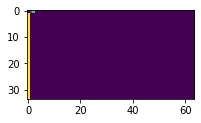

Count 600 | 4호선 쌍문역 쪽인데 대중교통으로 가는 방법 있나요? ____ => <s>아우선자문멱적윤데 배중도 터요 가년 발마 있나요?</s> => 아기                                


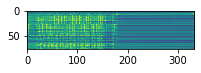

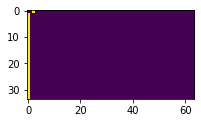

Count 800 | 단체도 예약이 가능한가요? ___ => 단체 예약  가 능가가요?  ??


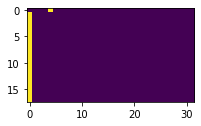

Count 800 | 단체도 예약이 가능한가요? ___ => <s>단체도예약이 가능한가요?</s> => 단체 예약  가 능가가요?   요


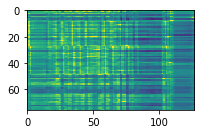

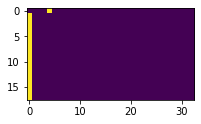

09-26 16:28:15
Mean Train Loss: 0.02959698647194768
Mean Train Seq2Seq Loss: 3.2006246770625624
Train CER: 0.8912380283045684
Mean Train Reference Seq2Seq Loss: 2.9082199857866438
Train Reference CER: 0.8478805729059218
Eval Count 50 | 버스정류장에서 어떻게 가면 되는 지 궁금합니다 ____ => 버희                            


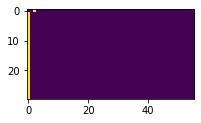

Eval Count 50 | 버스정류장에서 어떻게 가면 되는 지 궁금합니다 ____ => <s>엿항이항서떻게 가는 제은제 강금합니다?</s> => 영업                            


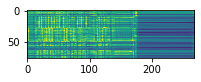

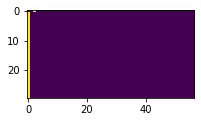

09-26 16:28:37
Mean Evaluation Loss: 0.030164758159897866
Mean Evaluation Seq2Seq Loss: 3.107782939202481
Evaluation CER: 0.8150927016804117
Mean Evaluation Reference Seq2Seq Loss: 2.641516482863728
Evaluation Reference CER: 0.7589388347752435


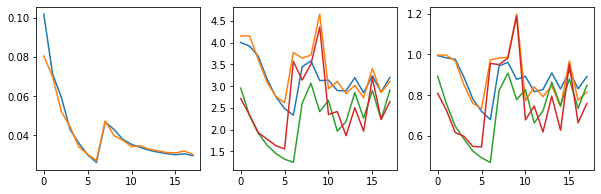

-------------------------------------------------------------------------------------------------------
09-26 16:28:38
Count 200 | (이벤트세트메뉴) 할인되나요? ___ => sk                  


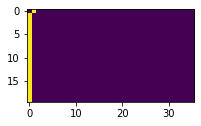

Count 200 | (이벤트세트메뉴) 할인되나요? ___ => <s>ㅂㅅ에 유ㅛ 아리있나요?</s> => 샐                   


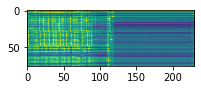

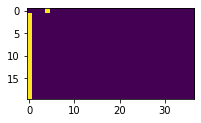

Count 400 | 가서 바로 먹을 수 있게 메뉴 주문도 가능한가요? __ => 식사                      ?   ? 


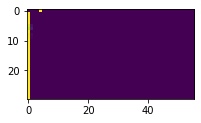

Count 400 | 가서 바로 먹을 수 있게 메뉴 주문도 가능한가요? __ => <s>아서 타로모흘 시ㅣ갤 메 중문도하능하나요?</s> => 아스                        ?   


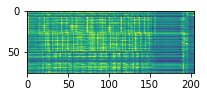

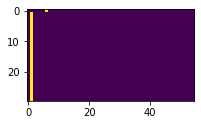

Count 600 | 오늘 몇 시까지 영업하나요? _ => 오늘 몇시시 영 영업시나요   


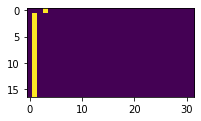

Count 600 | 오늘 몇 시까지 영업하나요? _ => <s>온뎌시깐이 여그아욤ㅊ시까이 ㅇ흐나요?</s> => 오늘 몇시시  시 시  시   


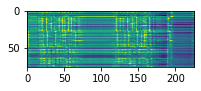

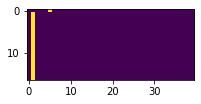

Count 800 | 지금 가장 인기있는 메뉴가 뭔가요? ____ => 지금 가가 메뉴  가가가가가가가가가     


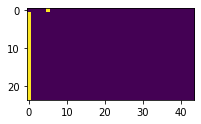

Count 800 | 지금 가장 인기있는 메뉴가 뭔가요? ____ => <s>지그 가당인티이는 메뉴가 뭔가요?</s> => 지가메      가가가가가가가가가가 ?   


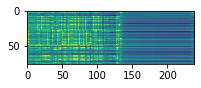

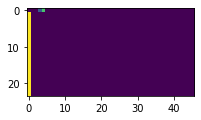

09-26 16:37:48
Mean Train Loss: 0.029000755612637805
Mean Train Seq2Seq Loss: 3.033963704391308
Train CER: 0.8749164089041571
Mean Train Reference Seq2Seq Loss: 2.6450565567855784
Train Reference CER: 0.81510536198623
Eval Count 50 | kt 할인 얼마나 되나요 _ => ktt할인 얼얼마마나   ?


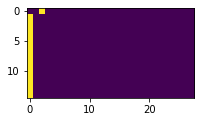

Eval Count 50 | kt 할인 얼마나 되나요 _ => <s>으ㅏ이 하이되서가나 다뇨?</s> => 아이      나나요??  


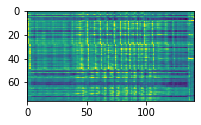

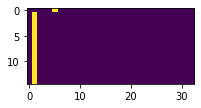

09-26 16:38:11
Mean Evaluation Loss: 0.029709160991974473
Mean Evaluation Seq2Seq Loss: 2.847197178424085
Evaluation CER: 0.7939232177772261
Mean Evaluation Reference Seq2Seq Loss: 2.308178981255943
Evaluation Reference CER: 0.7240347018572825


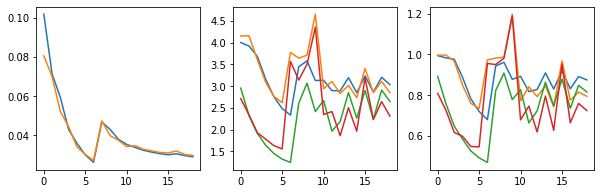

-------------------------------------------------------------------------------------------------------
09-26 16:38:11
Count 200 | 어린이 할인은 몇살 까지 받을 수 있나요? ___ => 어린이 할인                     


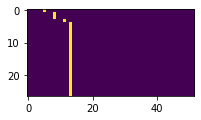

Count 200 | 어린이 할인은 몇살 까지 받을 수 있나요? ___ => <s>아린이 할인을ㄴ 몇 살까지 갇을 수있나요?</s> => 카림이 할                      


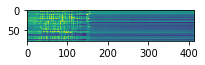

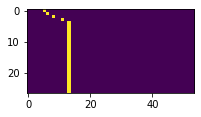

Count 400 | 발레파킹 가능한가요? ___ => 발레파킹  가능능      


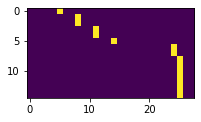

Count 400 | 발레파킹 가능한가요? ___ => <s>알이 가킹 가능한가요?</s> => 할요             


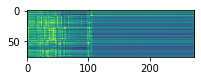

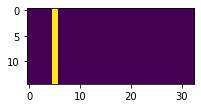

Count 600 | 브레이크 타임은 몇시부터 몇시까지에요? _ => 몇시시                    


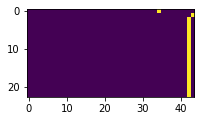

Count 600 | 브레이크 타임은 몇시부터 몇시까지에요? _ => <s>아ㅔ이크타임은 몇시부터 몇시까지애요?</s> => 몇시시                    


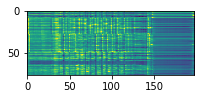

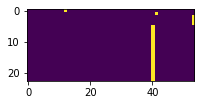

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => 혹시                                                


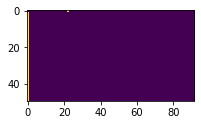

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>배정하데늄마시타지 사든제했는데 주처인버으로 멤버십판우 종애 가능한지요?</s> => 제일                                                


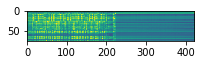

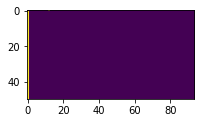

09-26 16:47:24
Mean Train Loss: 0.028573332888371238
Mean Train Seq2Seq Loss: 3.1939216618984125
Train CER: 0.9094154623650652
Mean Train Reference Seq2Seq Loss: 2.828891544321335
Train Reference CER: 0.8617517681842989
Eval Count 50 | 런치메뉴는 몇 시까지 판매인가요? ___ => 런치                  ? 


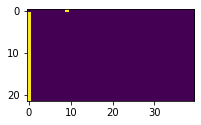

Eval Count 50 | 런치메뉴는 몇 시까지 판매인가요? ___ => <s>언치 메뉴는 몇시까주 바는해인가요?</s> => 런치                   ?


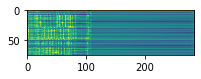

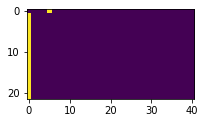

09-26 16:47:47
Mean Evaluation Loss: 0.02958954537478744
Mean Evaluation Seq2Seq Loss: 3.273670825703555
Evaluation CER: 0.9378685503685503
Mean Evaluation Reference Seq2Seq Loss: 3.0250330889283585
Evaluation Reference CER: 0.9147177721215751


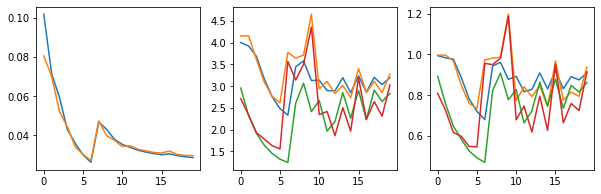

-------------------------------------------------------------------------------------------------------
09-26 16:47:47


KeyboardInterrupt: 

In [25]:
EPOCH = 6 * 10
           
# net = Mel2SeqNet(80, 512, 256)


# net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut'
# net = Mel2SeqNet(80, 512, 256, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024'

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)
net_optimizer = optim.Adam(net.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss().to(device)

# try:
#     load(net, net_optimizer, 'model_saved/{}'.format(keyword))
# except:
#     print('Failed to load model')

keyword = 'NSML_jamo_seq2seq_from_scratch_loss_large'

jamo2char_net = Seq2SeqNet(512, jamo_tokens, char2index, device)
jamo2char_optimizer = optim.Adam(jamo2char_net.parameters(), lr=0.001)
seq2seq_criterion = nn.NLLLoss(reduction='none').to(device)

train_loss_history = list()
eval_loss_history = list()

train_seq2seq_loss_history = list()
eval_seq2seq_loss_history = list()

train_seq2seq_loss_history_ref = list()
eval_seq2seq_loss_history_ref = list()

train_cer_history = list()
eval_cer_history = list()

train_cer_history_ref = list()
eval_cer_history_ref = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history_{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history_{}.npy'.format(keyword)))
except:
    print("No CER Record")
    
try:
    load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    train_seq2seq_loss_history = list(np.load('model_saved/train_seq_loss_history_{}.npy'.format(keyword)))
    eval_seq2seq_loss_history = list(np.load('model_saved/eval_seq_loss_history_{}.npy'.format(keyword)))
except:
    print('No Seq2Seq Loss Record')
    
try:
#     load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Loss History Error".format(keyword))

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

min_loss_net = 1e+10
min_loss_seq = 1e+10

for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    
    try:
        load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    except:
        print('Could not found model_saved/{}'.format(keyword))
        
    try:
        load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    except:
        print('Could not found model_saved/seq_{}'.format(keyword))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()
    seq2seq_loss_list_train = list()
    seq2seq_loss_list_train_ref = list()

    total_dist = 0
    total_length = 1
    total_dist_ref = 0
    total_length_ref = 1
    
    count = 0
    net.train()
    jamo2char_net.train()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)

            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            
            lev_input_ref = ground_truth
            lev_pred_ref, attentions_ref, seq2seq_loss_ref = jamo2char_net.net_train(lev_input_ref.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
            pred_string_list_ref = Decode_Lev(lev_pred_ref, index2char)
            seq2seq_loss_list_train_ref.append(seq2seq_loss_ref)
            dist_ref, length_ref = char_distance_list(true_string_list, pred_string_list_ref)
            
            pred_string_list = [None]
            
            dist = 0
            length = 0
            
            if (loss < 0.05):
                lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
                lev_pred, attentions, seq2seq_loss = jamo2char_net.net_train(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
                pred_string_list = Decode_Lev(lev_pred, index2char)
                seq2seq_loss_list_train.append(seq2seq_loss)  
                dist, length = char_distance_list(true_string_list, pred_string_list)                

            total_dist_ref += dist_ref
            total_length_ref += length_ref
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 200 == 0:
                print("Count {} | {} => {}".format(count, true_string_list[0], pred_string_list_ref[0]))
                
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions_ref[0].detach().cpu().numpy().T)
                plt.show()
                
                print("Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy().T)
                plt.show()
                
                if pred_string_list[0] is not None:
                    plt.figure(figsize = (3, 3))
                    plt.imshow(attentions[0].detach().cpu().numpy().T)
                    plt.show()

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    train_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_train))
    
    train_cer_ref = total_dist_ref / total_length_ref
    train_seq2seq_loss_ref = np.mean(np.asarray(seq2seq_loss_list_train_ref))
    
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Mean Train Seq2Seq Loss: {}".format(train_seq2seq_loss))
    print("Train CER: {}".format(train_cer))
    print("Mean Train Reference Seq2Seq Loss: {}".format(train_seq2seq_loss_ref))
    print("Train Reference CER: {}".format(train_cer_ref))
    
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    train_cer_history_ref.append(train_cer_ref)
    
    train_seq2seq_loss_history.append(train_seq2seq_loss)
    train_seq2seq_loss_history_ref.append(train_seq2seq_loss_ref)
    
    ###########################################################
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()
    seq2seq_loss_list_eval = list()
    seq2seq_loss_list_eval_ref = list()

    total_dist = 0
    total_length = 1
    total_dist_ref = 0
    total_length_ref = 1
    
    net.eval()
    jamo2char_net.eval()
    
    count = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch
            pred_tensor, loss = evaluate(net, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            
            lev_input_ref = ground_truth
            lev_pred_ref, attentions_ref, seq2seq_loss_ref = jamo2char_net.net_eval(lev_input_ref.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
            pred_string_list_ref = Decode_Lev(lev_pred_ref, index2char)
            seq2seq_loss_list_eval_ref.append(seq2seq_loss_ref)
            dist_ref, length_ref = char_distance_list(true_string_list, pred_string_list_ref)
            
            pred_string_list = [None]
            
            dist = 0
            length = 0
            
            if (loss < 0.05):
                lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
                lev_pred, attentions, seq2seq_loss = jamo2char_net.net_eval(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
                pred_string_list = Decode_Lev(lev_pred, index2char)
                seq2seq_loss_list_eval.append(seq2seq_loss)  
                dist, length = char_distance_list(true_string_list, pred_string_list)
                                
            total_dist_ref += dist_ref
            total_length_ref += length_ref
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 50 == 0:
                print("Eval Count {} | {} => {}".format(count, true_string_list[0], pred_string_list_ref[0]))
                
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions_ref[0].detach().cpu().numpy().T)
                plt.show()
                
                print("Eval Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy().T)
                plt.show()
                
                if pred_string_list[0] is not None:
                    plt.figure(figsize = (3, 3))
                    plt.imshow(attentions[0].detach().cpu().numpy().T)
                    plt.show()
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    eval_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_eval)) ##############
    
    eval_cer_ref = total_dist_ref / total_length_ref
    eval_seq2seq_loss_ref = np.mean(np.asarray(seq2seq_loss_list_eval_ref)) ##############
    

    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Mean Evaluation Seq2Seq Loss: {}".format(eval_seq2seq_loss)) ##################
    print("Evaluation CER: {}".format(eval_cer))
    print("Mean Evaluation Reference Seq2Seq Loss: {}".format(eval_seq2seq_loss_ref)) ##################
    print("Evaluation Reference CER: {}".format(eval_cer_ref))
    
    
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    eval_cer_history_ref.append(eval_cer_ref)
    
    eval_seq2seq_loss_history.append(eval_seq2seq_loss) ##################
    eval_seq2seq_loss_history_ref.append(eval_seq2seq_loss_ref) ##################
    
    #####
    
#     if min_loss_net > train_loss:
#         min_loss_net = train_loss

    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    
    if min_loss_seq > train_seq2seq_loss:
        min_loss_seq = train_seq2seq_loss
        save(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    
    np.save('model_saved/train_seq_loss_history_{}'.format(keyword), train_seq2seq_loss_history)
    np.save('model_saved/eval_seq_loss_history_{}'.format(keyword), eval_seq2seq_loss_history)
    
    np.save('model_saved/train_cer_history_{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history_{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure(figsize=(10, 3))
    plt.subplot(131)
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)

    plt.subplot(132)
    plt.plot(train_seq2seq_loss_history)
    plt.plot(eval_seq2seq_loss_history)
    
    plt.plot(train_seq2seq_loss_history_ref)
    plt.plot(eval_seq2seq_loss_history_ref)

    plt.subplot(133)
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    
    plt.plot(train_cer_history_ref)
    plt.plot(eval_cer_history_ref)
    
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    
    